In [1]:
import nest_asyncio
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI

from src.database import VectorDB
from src.model import *
from src.model_grader import *
from src.utils import check_required_env_vars

nest_asyncio.apply()
load_dotenv()

False

In [2]:
check_required_env_vars()

{}

In [3]:
db = VectorDB()
db.enable_hnsw_indexing()

HNSW extension and index created successfully.


In [ ]:
# query = """Tell me about the Liberty of the person under the constitution of Singapore:
# (5)  Clauses (3) and (4) shall not apply to an enemy alien or to any person arrested for 
# contempt of Parliament pursuant to a warrant issued under the hand of the Speaker."""
# query = "Can I count to the number 30 with someone else's hands?"
# query = "Is it legal to call someone a 'dumb dumb bubblegum'?"
# query = "人を殺すってだめですか？"
# query = "Would it be illegal if I went 'bippity boppity, I'mma steal your intellectual property' in Singapore?"
# query = "Is it illegal to be stupid in Singapore?"
query = "I want to play Monster Hunter Wilds, but it's $100. :("

vectorstore_summary = "It includes the reliable information of the constitution of the republic of Singapore."

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

inputs = {
    "query": query,
    "db": db,
    "model": model,
    "vectorstore_summary": vectorstore_summary,
    "retrieved_docs":[""],
    "depth": 0,
    "excluded_file_ids": set(),
}

response = build_graph()
app = response.compile()

output = app.invoke(inputs)

In [59]:
from pprint import pprint

pprint(output)

{'complexity': 'high',
 'db': <src.database.VectorDB object at 0x78fdb03eb770>,
 'depth': 0,
 'excluded_file_ids': set(),
 'model': ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x78fd6399c5f0>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x78fd633e1b50>, root_client=<openai.OpenAI object at 0x78fd63818950>, root_async_client=<openai.AsyncOpenAI object at 0x78fd6399d520>, model_name='gpt-4o-mini', temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********')),
 'query': '人を殺すってだめですか？',
 'response': {'messages': [HumanMessage(content='人を殺すってだめですか？', additional_kwargs={}, response_metadata={}, id='5c277690-21c9-420d-85a0-ab8838a071ee'),
                           AIMessage(content='はい、人を殺すことは法律に反しており、倫理的にも許されません。人の命を奪うことは重大な犯罪であり、社会に対しても大きな影響を与えます。もし何か悩みや問題がある場合は、信頼できる人に相談することをお勧めします。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_toke

In [55]:
print(output["response"].content)

### **Legal Response**

- **Legal Basis**: The retrieved legal context does not provide any specific clauses or laws directly related to the pricing of video games or consumer rights in Singapore. However, general consumer protection laws may apply, such as the Consumer Protection (Fair Trading) Act (Cap. 52A) which prohibits unfair trading practices.

- **Explanation**: The Consumer Protection (Fair Trading) Act aims to protect consumers against unfair practices in the marketplace. While the Act does not specifically regulate the pricing of goods, it does ensure that consumers are not subjected to misleading advertisements or unfair terms in contracts. If a game is priced at $100, it is within the retailer's rights to set that price, provided that it is not misleadingly advertised or accompanied by unfair terms.

- **Conclusion**: In the absence of specific legal provisions regarding the pricing of video games, the price of $100 for Monster Hunter Wilds is legally permissible under Si

In [56]:
response = output["response"].content

# query = "Who is the protagonist of the Halo series?"
# response = "Arbiter is the playable character in Halo."

inputs = {
    "query": query,
    "response": response,
    "model": model,
}

grading_graph = build_response_grader_graph()
grading_app = grading_graph.compile()

grading_output = grading_app.invoke(inputs)
print(f"Hallucination: {grading_output["hallucination"]}")
print(f"Quality: {grading_output["quality"]}")
print(f"Compliance: {grading_output["compliance"]}")

Hallucination: False
Quality: True
Compliance: True


In [57]:
pprint(grading_output)

{'compliance': True,
 'compliance_reason': ' "The response accurately reflects the principles of '
                      'the Consumer Protection (Fair Trading) Act and aligns '
                      'with Singaporean law regarding pricing and consumer '
                      'rights."',
 'hallucination': False,
 'hallucination_reason': ' "The statement accurately reflects the general '
                         'principles of consumer protection laws in Singapore, '
                         'specifically the Consumer Protection (Fair Trading) '
                         'Act, and correctly explains the legal context '
                         'regarding pricing practices."',
 'model': ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x78fd63884470>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x78fd61af6060>, root_client=<openai.OpenAI object at 0x78fd63894830>, root_async_client=<openai.AsyncOpenAI object 

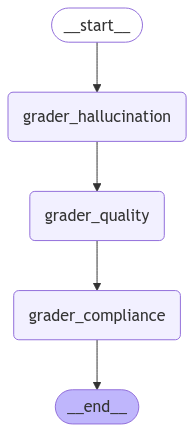

In [9]:
grading_app

In [10]:
output["response"]["messages"][-1].content

TypeError: 'AIMessage' object is not subscriptable